# Create a Machine Learning Model for Unsupervised Text Topic Classification
Part 1 of 2
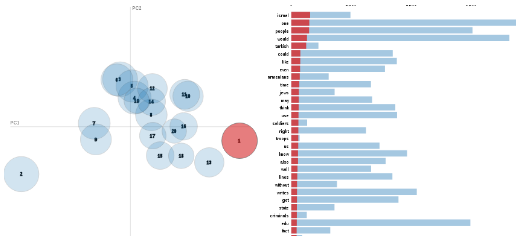
## Introduction
In this tutorial notebook we will use the <a href="https://radimrehurek.com/gensim/about.html" target="_blank" rel="noopener noreferrer">gensim</a> library to create a <a href="https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation" target="_blank" rel="noopener noreferrer">Latent Dirichlet allocation (LDA)</a> machine learning <a href="https://en.wikipedia.org/wiki/Topic_model" target="_blank" rel="noopener noreferrer">topic model</a>. LDA is an _unsupervised_ model, so the topics which are identified during training are assigned a number (for a _label_) and described by a group of terms, where each term is coupled with a weight.

We will use a sample newsgroup dataset <a href="https://rare-technologies.com/new-api-for-pretrained-nlp-models-and-datasets-in-gensim/" target="_blank" rel="noopener noreferrer">provided by gensim</a> for the purposes of training and scoring.
***
This is part 1 of this tutorial notebook series, where we will perform the following:
* create/train the model
* visualize it with <a href="http://pyldavis.readthedocs.io/en/latest/" target="_blank" rel="noopener noreferrer">pyLDAvis</a>
* save the model on __Bluemix Cloud Object Storage__.

<font color=red>**UPDATE LINK!!!**</font>  
In [part 2](https://dataplatform.ibm.com/analytics/notebooks/v2/abf17c29-ff75-4b59-a67c-411eda75e547/view?access_token=d82dd17f147bce9084bda230a4243133ab3f27cd29baf3a0fad750e7e03e3aee), we will create a __Streams Flow__ using __Streams Designer__, which uses the model to perform real-time topic classification on news items from the dataset. The results will be also be saved to __Bluemix Cloud Object Storage__.

Some familiarity with Python is recommended. This notebook has been verified for Python 3.5, Spark 2.1 and gensim 2.2.

## <a id="TOC"></a> Table of contents
1. [Setup](#setup)<br>
    1.1 [Import / Install prerequisite packages](#setup1)<br>
    1.2 [Provide Credentials for Cloud Object Storage (COS)](#setup2)<br>
    1.3 [Provide COS bucket and object names](#setup3)<br>
    1.4 [Download the sample dataset](#setup4)<br>
2. [Define functions](#define)<br>
    2.1 [function: read_dataset](#define1)<br>
    2.2 [function: preprocess_texts](#define2)<br>
    2.3 [function: train_model](#define3)<br>
    2.4 [function: package_model](#define4)<br>
    2.5 [function: save_to_cos](#define5)<br>
3. [Create the model](#train)<br>
4. [Display the topic model visualization](#visualize)<br>
5. [Save the model and topic terms to Cloud Object Storage](#save)<br>
6. [Summary and next steps](#summary)<br>

<a id="setup"></a>
## 1. [Setup](#TOC)

<a id="setup1"></a>
### 1.1 [Install prerequisite packages](#TOC)
Make sure that these packages are installed. To install:
* Un-comment the _pip install_ commands and _Run_ the cell.
* Restart the kernel (preferably _Restart and Clear Output_).
* Return the comments to the commands (since they will be unnecessary the next time your run the notebook).

It is recommended to install gensim version 2.2 as this is the version installed on the _Bluemix Streaming Analytics_ service at the time this notebook was tested.

!pip list
!pip install pandas==0.19.2 --user

!pip install --user gensim==2.2

!pip install --user stop-words

!pip install --user pyLDAvis
!pip list

# RESTART kernel

<a id="setup2"></a>
### 1.2 [Provide Credentials for Cloud Object Storage (COS)](#TOC)
The COS credentials will be used at the end of this tutorial for storing the created model.

You can copy your credentials from the __Bluemix Dashboard__ `Service credentials` page of your __Cloud Object Storage__  service.

You can replace the entire content of the **cos_credentials** variable with your credentials, or provide only your <font color=blue>'apikey'</font> and rely on the defaults used in the **save_to_cos** function.  
Make sure that the <font color=red>_name_</font> of the credentials variable is set to **cos_credentials**.

In [45]:
# @hidden_cell
#INSERT YOUR COS CREDENTIALS
cos_credentials = {
  "apikey": "<REPLACE>",
}

<a id="setup3"></a>
### 1.3 [Provide COS bucket and object names](#TOC)
Choose a COS bucket name and object names for your packaged model (.gz) and topic-terms (.csv) files. 
<font color=red>Be sure that the bucket already exists!</font>

In [2]:
model_bucket_name = 'pyml'
model_object_name = 'LDA_news.model.pkg.gz'
topic_object_name = 'LDA_news.topic_terms.csv'

<a id="setup4"></a>
### 1.4 [Download the sample dataset](#TOC)
Version 3.2 of gensim (December 2017) includes a mechanism for [downloading](https://radimrehurek.com/gensim/downloader.html) some sample datasets.
Even if you have a previous version of gensim, you can still download the sample dataset directly from the gensim (RaRe-Technologies) github repository (based on the source code at https://github.com/RaRe-Technologies/gensim/blob/master/gensim/downloader.py).

We will use the __20-newsgroup__ dataset, which is described as: "The notorious collection of approximately 20,000 newsgroup posts, partitioned (nearly) evenly across 20 different newsgroups."

In [3]:
DOWNLOAD_BASE_URL = "https://github.com/RaRe-Technologies/gensim-data/releases/download"
dataset="20-newsgroups"

#!rm -f {dataset}.gz*
![[ ! -f {dataset}.gz ]] && wget '{DOWNLOAD_BASE_URL}/{dataset}/{dataset}.gz'
!pwd && ls -l {dataset}.gz*

/gpfs/fs01/user/sca9-7277eb31bca08b-bc196c953de3/notebook/work
-rw------- 1 sca9-7277eb31bca08b-bc196c953de3 users 14483581 Nov  9 17:44 20-newsgroups.gz


<a id="define"></a>
## 2. [Define functions](#TOC)

<a id="define1"></a>
### 2.1 [function: read_dataset](#TOC)
Load the dataset and create a List of texts. (All stored in memory, so assume a small dataset.) 
The dataset file should be in JSON format and contain a key called **data**.

Parameters:
* dataset_path: Path and filename of the dataset file.
* max_lines: If greater than 0, abort reading the file after max_lines lines.

Returns:
* texts: List of the text documents.

In [4]:
def read_dataset(dataset_path, max_lines=0):
    from smart_open import smart_open
    import json

    print("opening...", dataset_path)
    
    texts = []
    with smart_open( dataset_path, 'rb') as infile:
        for i, line in enumerate(infile):
            if max_lines > 0 and i == max_lines:
                break
            jsonData = json.loads(line.decode('utf8'))
            texts.append(jsonData['data'])

    print(len(texts), "lines read")

    return texts

<a id="define2"></a>
### 2.2  [function: preprocess_texts](#TOC)
Steps to pre-process and cleanse texts:
1. Stopword Removal.
2. Collocation detection (bigram).
3. Lemmatization (not stem since stemming can reduce the interpretability).
    
Parameters:
* texts: List of texts.
* stoplist: List of stopword tokens (from _nltk.corpus.stopwords.words('english')_).
* lemmatizer: [optional] Lemmatizer (from _nltk.stem.WordNetLemmatizer()_).    

Returns:
* tokens: Pre-processed tokenized texts.
* bigram_phraser: The bigram phraser which was created using all of the training data.

In [161]:
# Adapted from https://github.com/RaRe-Technologies/gensim/blob/master/docs/notebooks/gensim_news_classification.ipynb
def preprocess_texts(texts, stoplist, lemmatizer=None):
#    from gensim import utils, models
#    import re

    # Convert to lowercase, remove accents, punctuation and digits. Tokenize and remove stop-words.
#    tokens = [[word for word in utils.tokenize(re.sub(r'(?i)(From|Organization|Lines|Nntp-Posting-Host|X-Newsreader): [^\n]*(\n)', '', text),
#                                               lowercase=True, deacc=True, errors="ignore")
#                     if word not in stoplist and len(word) > 2]
#               for text in texts]
    
    tokens = [[word for word,wordtype in nltk.pos_tag(
                    [word for word in set(utils.tokenize(
                                        re.sub(r'(?i)(From|Organization|Lines|Nntp-Posting-Host|X-Newsreader): [^\n]*(\n)', '', text), 
                                        lowercase=True, deacc=True, errors="ignore"))
                        if len(word) > 2])
                if wordtype in ['NNS','NN']]
              for text in texts]

    # bigram collocation detection
    bigram = models.Phrases(tokens)
    bigram_phraser = models.phrases.Phraser(bigram)
    tokens = [bigram_phraser[text] for text in tokens]

    if lemmatizer:
        tokens = [[word for word in lemmatizer.lemmatize(' '.join(text), pos='v').split()] for text in tokens]

    return tokens, bigram_phraser

<a id="define3"></a>
### 2.3 [function: train_model](#TOC)
Steps to create the model:
1. Create a Dictionary using the List of cleansed tokenized text.
2. [optional] Filter extremes.
3. Create a corpus from the Bag-of-Words method.  
    The BOW method takes the text tokens (words) and returns a list of tuples containing
    the word's token-id within the dictionary, and it's frequency within the input text.
4. Create and train an LDA model. Play around with the hyperparameters to affect speed and quality.

Parameters:
* textTokens: List of cleansed documents, where each document is represented by a List of tokens.

Results:
* model: The trained LDA model.
* dictionary: The dictionary created from the tokenized text.
* textBOW: The corpus used in creating the model

In [6]:
def train_model(textTokens):
    from gensim import corpora, models

    # Create the dictionary
    dictionary = corpora.Dictionary( documents=textTokens)
    
    # Optional: Filter out tokens which are in less than 10 and more than 75.0% of the documents
    ##### dictionary.filter_extremes(no_below=10, no_above=0.75, keep_n=50000)

    # The training corpus is the result of the Bag-of-Words method.
    textBOW = [dictionary.doc2bow(text) for text in textTokens]

    # Create the gensim LDA model. Choose the best hyper-parameters. For example, try: iterations=100, passes=3
    model = models.ldamodel.LdaModel( corpus=textBOW, id2word=dictionary,
                                      num_topics=20, update_every=0.5,
                                      iterations=50, passes=3)
#                                      iterations=10, passes=1) # RECOMMENDED ONLY FOR FASTER TESTING

    return model, dictionary, textBOW

<a id="define4"></a>
### 2.4 [function: package_model](#TOC)
Package the model, phraser and creation timestamp into a pickled (serialized) and gzip-ed object.

Parameters:
* model: The LDA model
* phraser: [optional] The bigram phraser

Results:
* timestamp: The package creation timestamp
* pkg_gz: The compressed package

In [7]:
def package_model(model, phraser=None):
    import pickle, gzip
    from time import strftime

    timestamp = strftime('%Y-%m-%d_%H.%M.%S')
    pkg = { 'timestamp': timestamp,
            'model': model,
            'phraser': phraser
          }
    pkg_gz = gzip.compress(pickle.dumps(pkg))
    
    return timestamp, pkg_gz

<a id="define5"></a>
### 2.5 [function: save_to_cos](#TOC)
Save an object to Cloud Object Storage (COS) using the REST API.

Parameters:
* cred: Dictionary of COS credentials. It may contain various key names, depending on where the credentials were copied from.
* bucket_name: COS bucket_name (must already exist!)
* object_name: Name of object to write.
* data: Serialized data to write.

In [8]:
def save_to_cos( cred, bucket_name, object_name, data):
    import requests

    default_iam_url = 'https://iam.ng.bluemix.net/oidc/token'
    default_endpoint = 'https://s3-api.us-geo.objectstorage.service.networklayer.com'
    
    api_key = cred.get('apikey', cred.get('api_key', cred.get('IBM_API_KEY_ID')))
    iam_url = cred.get('iam_url', cred.get('IBM_AUTH_ENDPOINT', default_iam_url))
    endpoint = cred.get('url', cred.get('ENDPOINT', default_endpoint))

    if not api_key:
        print("ERROR: Missing api key")
        return

    full_object_path = bucket_name + "/" + object_name
    print("Saving", full_object_path, "(", str(len(data)), "bytes)")

    response = requests.post(
                url = iam_url,
                headers = {"Content-Type": "application/x-www-form-urlencoded"},
                params = {"grant_type":"urn:ibm:params:oauth:grant-type:apikey","apikey":api_key},
                verify = True)
    if response.status_code != 200:
        print( "ERROR: POST Response =", response.status_code, response.reason, response.text)
        return
    bearer_token = response.json()["access_token"]
    
    response = requests.put(
                url = endpoint + "/" + full_object_path,
                headers = {"Authorization": "bearer " + bearer_token},
                data = data)    
    if response.status_code != 200:
        print( "ERROR: PUT Response =", response.status_code, response.reason, response.text)

<a id="train"></a>
## 3. [Create the model](#TOC)

The following steps will be performed:
* Download the NLTK collection of stop words.
* Download the NLTK lemmatizer used in pre-processing the text.
* Read a subset of the sample dataset to use for training.
* Pre-process and cleanse the text data.
* Train the LDA model.
* Display some of the topic terms identified by the model.

### Ignore deprication warnings.  
[Optional] Set the logging level to display more or less messages. The gensim library provides many interesting progress messages.
* Change the default level to _logging.ERROR_ to see fewer messages. Valid levels are: _CRITICAL, ERROR, WARNING, INFO, DEBUG, NOTSET_
* You can change the level at any time with these commands:
```
logger = logging.getLogger()
logger.setLevel( logging.ERROR)
```

In [9]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore', 'DeprecationWarning')

# Optional: Set the default logging level.
import logging
#logging.basicConfig( level=logging.INFO, format='%(asctime)s : %(name)s.%(funcName)s : %(levelname)s : %(message)s')

logging.basicConfig( level=logging.ERROR, format='%(asctime)s : %(name)s.%(funcName)s : %(levelname)s : %(message)s')

### Load the stoplist and lemmatizer from NLTK

In [10]:
import nltk
from sklearn.feature_extraction import stop_words
from stop_words import get_stop_words

nltk.download("wordnet")
lemmatizer = nltk.stem.WordNetLemmatizer()

# sklearn has 318 stop words
stoplist = set(stop_words.ENGLISH_STOP_WORDS)
print("Stop words:", len(stoplist))

# nltk has 179 stop words
nltk.download("stopwords")
stoplist.update(nltk.corpus.stopwords.words("english"))
print("Stop words:", len(stoplist))

# stop_words has 174 stop words
stoplist.update(get_stop_words('english'))
print("Stop words:", len(stoplist))

# sklearn (318) + nltk(179) = 378 + stop_words(174) = 407

#stoplist.update({"MANUALLY", "ADDED", "ELEMENTS"})

[nltk_data] Downloading package wordnet to /gpfs/fs01/user/sca9-7277eb
[nltk_data]     31bca08b-bc196c953de3/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Stop words: 318
[nltk_data] Downloading package stopwords to /gpfs/fs01/user/sca9-7277
[nltk_data]     eb31bca08b-bc196c953de3/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Stop words: 378
Stop words: 407


import nltk

STOP_TYPES = ['DET', 'CNJ']

text = "some data here "
tokens2 = nltk.pos_tag(nltk.word_tokenize(text))
#good_words = [w for w, wtype in tokens if wtype not in STOP_TYPES]

print(len(textTokens))
all_tokens = sum(textTokens, [])
print(len(all_tokens))

u'would' in all_tokens

### Train the model

The 20-newsgroups dataset has 18846 entries. Let's take 5000 for training (this is not necessary a recommended ratio).

In [162]:
texts = read_dataset(dataset + ".gz", 5000)

opening... 20-newsgroups.gz
5000 lines read


In [46]:
texts[0][0:350]

'From: db7n+@andrew.cmu.edu (D. Andrew Byler)\nSubject: Re: Serbian genocide Work of God?\nOrganization: Freshman, Civil Engineering, Carnegie Mellon, Pittsburgh, PA\nLines: 61\n\nVera Shanti Noyes writes;\n\n>this is what indicates to me that you may believe in predestination.\n>am i correct?  i do not believe in predestination -- i believe we all\n>choose '

In [47]:
re.sub( r'[^ @]+@[^ @]+', '', texts[0][0:350])

'From:  (D. Andrew Byler)\nSubject: Re: Serbian genocide Work of God?\nOrganization: Freshman, Civil Engineering, Carnegie Mellon, Pittsburgh, PA\nLines: 61\n\nVera Shanti Noyes writes;\n\n>this is what indicates to me that you may believe in predestination.\n>am i correct?  i do not believe in predestination -- i believe we all\n>choose '

Pre-process and cleanse the texts

In [163]:
%time textTokens, bigram_phraser = preprocess_texts( texts, stoplist, lemmatizer)
print(len(sum(textTokens, [])))
# 624665, 564065, 581009, 217411

CPU times: user 59.6 s, sys: 0 ns, total: 59.6 s
Wall time: 59.6 s
217411


Train the model (save the dictionary and corpus for visualization)

In [164]:
%time model, dictionary, corpus = train_model( textTokens)

CPU times: user 1min 14s, sys: 1min 7s, total: 2min 21s
Wall time: 1min 15s


Retrieve the topic terms from the model

In [165]:
# Retrieve the topic terms from the model
topicTerms = model.print_topics(num_topics=-1, num_words=10)

In [166]:
for tt in topicTerms:
    print("Topic={0}, Terms={1}...".format(tt[0],tt[1]), end="\n\n")

Topic=0, Terms=0.011*"des" + 0.006*"pgp" + 0.005*"israel" + 0.004*"propaganda" + 0.003*"news" + 0.003*"distribution" + 0.003*"mail" + 0.003*"doesn" + 0.003*"article" + 0.003*"world"...

Topic=1, Terms=0.007*"amendment" + 0.006*"turkey" + 0.005*"anti" + 0.004*"inet" + 0.004*"article" + 0.004*"years" + 0.003*"nobody" + 0.003*"trade" + 0.003*"player" + 0.003*"shearson"...

Topic=2, Terms=0.011*"encryption" + 0.008*"chip" + 0.004*"system" + 0.004*"distribution" + 0.003*"accuracy" + 0.003*"devices" + 0.003*"chips" + 0.003*"armenians" + 0.003*"information" + 0.003*"systems_government"...

Topic=3, Terms=0.006*"crimes" + 0.006*"article" + 0.004*"shots" + 0.004*"homeland" + 0.003*"information_system" + 0.003*"anyone" + 0.003*"president_state" + 0.003*"com" + 0.003*"cmhnet" + 0.003*"buildings"...

Topic=4, Terms=0.008*"government" + 0.005*"agencies" + 0.005*"keys" + 0.004*"article" + 0.004*"millions" + 0.004*"thousands" + 0.003*"people" + 0.003*"crime" + 0.003*"news" + 0.002*"data"...

Topic=5,

Display a sampling of the identified topic terms

In [16]:
for tt in topicTerms[:5]:
    print("Topic={0}, Terms={1}...".format(tt[0],tt[1][:120]), end="\n\n")

Topic=0, Terms=0.013*"said" + 0.010*"people" + 0.007*"told" + 0.006*"know" + 0.006*"like" + 0.006*"apartment" + 0.005*"children" + 0.00...

Topic=1, Terms=0.008*"subject" + 0.007*"edu" + 0.006*"car" + 0.006*"people" + 0.005*"writes" + 0.004*"new" + 0.004*"like" + 0.003*"know...

Topic=2, Terms=0.006*"people" + 0.006*"subject" + 0.005*"point" + 0.005*"know" + 0.005*"like" + 0.005*"writes" + 0.005*"believe" + 0.00...

Topic=3, Terms=0.011*"people" + 0.007*"israel" + 0.005*"know" + 0.005*"encryption" + 0.004*"jews" + 0.004*"god" + 0.003*"government" + ...

Topic=4, Terms=0.013*"armenian" + 0.012*"armenians" + 0.009*"gun" + 0.006*"people" + 0.005*"fbi" + 0.005*"right" + 0.005*"nsa" + 0.004*...



The result of the above command displays a topic number followed by a group of terms, where each term is coupled with its weight within the topic.

<a id="visualize"></a>
## 4. [Display the topic model visualization](#TOC)
We will use the pyLDAvis, which you can read about at http://pyldavis.readthedocs.io/en/latest/ and https://github.com/bmabey/pyLDAvis.

When the display is ready, you can use the interactive visualization to explore the dominant terms of the topics.

In [225]:
#%%time
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim.prepare( model, corpus, dictionary)

pyLDAvis.display(vis)

<a id="save"></a>
## 5. [Save the model and topic terms to Cloud Object Storage](#TOC)
* Package the model and phraser into a dictionary object, which can be serialized and compressed to a file.
* Save the file to COS.

# Package the model and phraser into a gzip object
ts, pkg_gz = package_model( model, bigram_phraser)
print("Package size: {} bytes; creation timestamp: {}".format(len(pkg_gz), ts))

# Stick the model creation timestamp into the name of the topic-terms file name
topic_object_name_ts = topic_object_name.replace('.csv','') + '.' + ts + '.csv'
print("Modified topic file name: {}".format(topic_object_name_ts))

#Package size: 13766805 bytes; creation timestamp: 2018-01-26_07.38.49
#Modified topic file name: LDA_news.topic_terms.2018-01-26_07.38.49.csv

In [ ]:
#import pickle
#print(len(pickle.dumps(model)))
#19912360

In [ ]:
cos_credentials = {
  "apikey": "2SozF9MkHGQULJZHZTiZOnidaLSc3zIqr3SkDUC0YD0t",
  "endpoints": "https://cos-service.bluemix.net/endpoints",
  "iam_apikey_description": "Auto generated apikey during resource-key operation for Instance - crn:v1:bluemix:public:cloud-object-storage:global:a/db0d062d2b4c0836e18618a5222d8068:22e3b946-6154-4032-8e8f-7cfb0b429602::",
  "iam_apikey_name": "auto-generated-apikey-d7f66b84-8aee-41fa-afbf-b74e33124126",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Manager",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/db0d062d2b4c0836e18618a5222d8068::serviceid:ServiceId-4a452452-14c8-428a-b1c2-aa910d8f9244",
  "resource_instance_id": "crn:v1:bluemix:public:cloud-object-storage:global:a/db0d062d2b4c0836e18618a5222d8068:22e3b946-6154-4032-8e8f-7cfb0b429602::"
}

# Write both files to COS
model_object_name = 'LDA_news.model.pkg.gz'
save_to_cos( cos_credentials, model_bucket_name, 'LDA_news.model.try1.pkg.gz', pkg_gz)

save_to_cos( cos_credentials, model_bucket_name, topic_object_name_ts, 
                '\n'.join([str(t[0]) + "," + t[1] for t in topicTerms]))

<a id="summary"></a>
## 6. [Summary and next steps](#TOC)

You have now created an LDA model and saved it to Cloud Object Storage.

<font color=red>**UPDATE LINK!!!**</font>  
Proceed to [part 2](https://dataplatform.ibm.com/analytics/notebooks/v2/abf17c29-ff75-4b59-a67c-411eda75e547/view?access_token=d82dd17f147bce9084bda230a4243133ab3f27cd29baf3a0fad750e7e03e3aee), to create a __Streams Flow__ using the __Streams Designer__, which uses the model we created to perform real-time topic classification on news items from the dataset.

### <a id="authors"></a>Authors
**Raanon Reutlinger** is a developer in the IBM Watson Data Platform team working on the __Streams Designer__ Bluemix (DSX) cloud service. Raanon has over 20 years experience in the IBM Software Group, working in Data Management, Big Data and Watson teams.
<hr>
Copyright &copy; IBM Corp. 2017,2018. This notebook and its source code are released under the terms of the MIT License.

In [17]:
def read_dataset22(dataset_path, max_lines=0):
    from smart_open import smart_open
    import json

    print("opening...", dataset_path)
    
    texts = []
    sets = set()
    train = 0
    other = 0
    with smart_open( dataset_path, 'rb') as infile:
        for i, line in enumerate(infile):
            if max_lines > 0 and i == max_lines:
                break
            jsonData = json.loads(line.decode('utf8'))
            texts.append({ 'text': jsonData['data'], 'newsgroup': jsonData['topic'] })
            sets.update({jsonData['set']})
            if jsonData['set'] == 'train':
                train += 1
            else:
                other += 1

    print(len(texts), "lines read")
    print(sets, train, other)

    return texts

In [168]:
def preprocess_text(text, stoplist, bigram_phraser, lemmatizer=None):
    """
    Steps to pre-process and cleanse a single text:
    1. Stopword Removal.
    2. Collocation detection (bigram).
    3. Lemmatization (not stem since stemming can reduce the interpretability).
    Parameters:
    * text: a single text string.
    * stoplist: list of stopword tokens (from nltk.corpus.stopwords.words('english'))
    * bigram_phraser: the bigram_phraser which was packaged with the trained model
    * lemmatizer: [optional] Lemmatizer (from nltk.stem.WordNetLemmatizer())
    Returns:
    * tokens: Pre-processed tokenized texts.
    """
    # Convert to lowercase, remove accents, punctuation and digits. Tokenize and remove stop-words and header fields. re.sub( r'[^ @]+@[^ @]+', '', x)
#    tokens = [word for word in utils.tokenize(re.sub(r'(?i)(From|Organization|Lines|Nntp-Posting-Host|X-Newsreader): [^\n]*(\n)', '', text),
#                                              lowercase=True, deacc=True, errors="ignore")
#                     if word not in stoplist and len(word) > 2]

#    text = re.sub(r'(?i)(From|Organization|Lines|Nntp-Posting-Host|X-Newsreader): [^\n]*(\n)', '', text)
#    tokens = [word for word in utils.tokenize(text, lowercase=True, deacc=True, errors="ignore") if len(word) > 2]
#    tokens = [word for word,wordtype in nltk.pos_tag(tokens) if wordtype in ['NNS','NN']]

    tokens = [word for word,wordtype in nltk.pos_tag(
                    [word for word in utils.tokenize(
                                        re.sub(r'(?i)(From|Organization|Lines|Nntp-Posting-Host|X-Newsreader): [^\n]*(\n)', '', text), 
                                        lowercase=True, deacc=True, errors="ignore")
                        if len(word) > 2])
                if wordtype in ['NNS','NN']]
    
    # bigram collocation detection
    if bigram_phraser:
        tokens = bigram_phraser[tokens]

    if lemmatizer:
        tokens = [word for word in lemmatizer.lemmatize(' '.join(tokens), pos='v').split()]

    return tokens

In [171]:
def get_topic(model, textTokens):
    """
    Use the model to determine the top topic for the preprocessed tokens of a text.
    Return tuple with the topic, it's terms (describing the topic) and the original text.
    """
    topicTerms = {}

    # The Bag-of-Words method takes the input text tokens (words) and returns a list of tuples
    # containing the word's token-id (within the model dictionary (id2word)) and the word's frequency within the input text.
    textBOW = model.id2word.doc2bow(textTokens)

    # Given the textBOW, use the model to get the top topic
#    print(model.get_document_topics(textBOW, minimum_probability=0.70))
    topTopicId = max( model[textBOW], key=lambda topic:topic[1])[0]

    # Retrieve the topic terms (top 10 most probable words) from the model to include with the output returned
    topTopicTerms = model.print_topic(topTopicId, topn=10)

    topicTerms['topic'] = topTopicId
    topicTerms['terms'] = topTopicTerms
    topicTerms['topics'] = model.get_document_topics(textBOW)

    return topicTerms

In [169]:
test_texts = read_dataset22(dataset+".gz")

opening... 20-newsgroups.gz
18846 lines read
{'train', 'test'} 11314 7532


In [23]:
from gensim import models, corpora, utils
import re

In [28]:
test_tokens = preprocess_text(test_texts[0]['text'], stoplist, bigram_phraser, lemmatizer)

In [29]:
test_terms = get_topic(model, test_tokens)

[(3, 0.8398508335005326), (11, 0.013895315458085962), (15, 0.1422818883812839)]


In [41]:
#test_textBOW = model.id2word.doc2bow(test_tokens)
print(model.get_document_topics(test_textBOW, minimum_probability=0.70))

[(3, 0.8398462090539431)]


In [175]:
%%time
newsgroupTopics = {}
# {'group': {'topic': count:}}
for text in test_texts[:10000]:
    test_tokens = preprocess_text(text['text'], stoplist, bigram_phraser, lemmatizer)
    topicTerms = get_topic(model, test_tokens)
    if newsgroupTopics.get(text['newsgroup']) == None: newsgroupTopics[text['newsgroup']] = {}
    newsgroupTopics[text['newsgroup']][topicTerms['topic']] = newsgroupTopics[text['newsgroup']].get(topicTerms['topic'],0) + 1

CPU times: user 3min 52s, sys: 59.4 s, total: 4min 52s
Wall time: 3min 54s


In [224]:
#print(newsgroupTopics)
#for ng in sorted(newsgroupTopics):
for ng in sorted(newsgroupTopics, key=lambda y: max(newsgroupTopics[y].items(), key=lambda x:x[1])):
    print("{0:30} {1}".format(ng, sorted(newsgroupTopics[ng].items(), key=lambda x:x[1], reverse=True )))

misc.forsale                   [(2, 113), (18, 106), (8, 66), (9, 53), (13, 33), (4, 28), (12, 27), (7, 25), (16, 22), (3, 18), (6, 18), (14, 18), (11, 17), (1, 16), (17, 12), (0, 4), (5, 3), (10, 3), (15, 2), (19, 1)]
comp.graphics                  [(4, 86), (18, 78), (17, 73), (7, 72), (2, 35), (0, 33), (16, 30), (11, 23), (13, 23), (3, 21), (12, 19), (1, 15), (5, 15), (6, 13), (14, 12), (8, 8), (15, 8), (19, 8), (9, 7), (10, 5)]
comp.windows.x                 [(4, 257), (7, 107), (18, 85), (17, 62), (16, 18), (2, 10), (19, 10), (0, 9), (11, 8), (1, 4), (8, 4), (12, 4), (3, 3), (9, 3), (10, 3), (5, 2), (14, 2), (6, 1), (13, 1)]
talk.politics.guns             [(6, 116), (16, 106), (10, 104), (9, 46), (5, 44), (2, 33), (1, 26), (19, 17), (18, 8), (8, 7), (0, 6), (11, 6), (3, 4), (7, 4), (12, 4), (15, 4), (17, 4), (4, 3), (13, 3), (14, 1)]
rec.sport.hockey               [(6, 180), (16, 62), (3, 53), (19, 53), (2, 49), (1, 35), (0, 28), (18, 25), (9, 20), (10, 19), (12, 17), (7, 11), (13

In [ ]:
#!rm -fr ~/nltk_data/tokenizers ~/nltk_data/taggers
#!ls -lR ~/nltk_data

In [99]:
import nltk
nltk.download('punkt')
nltk.download('maxent_treebank_pos_tagger')
nltk.download('taggers')
nltk.download('averaged_perceptron_tagger')
#averaged_perceptron_tagger/averaged_perceptron

#STOP_TYPES = ['DET', 'CNJ']

#text = "some data here "
tokens1 = nltk.pos_tag(test_tokens)
#good_words = [w for w, wtype in tokens if wtype not in STOP_TYPES]

[nltk_data] Downloading package punkt to /gpfs/fs01/user/sca9-7277eb31
[nltk_data]     bca08b-bc196c953de3/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package maxent_treebank_pos_tagger to /gpfs/fs
[nltk_data]     01/user/sca9-7277eb31bca08b-bc196c953de3/nltk_data...
[nltk_data]   Unzipping taggers/maxent_treebank_pos_tagger.zip.
[nltk_data] Error loading taggers: Package 'taggers' not found in
[nltk_data]     index
[nltk_data] Downloading package averaged_perceptron_tagger to /gpfs/fs
[nltk_data]     01/user/sca9-7277eb31bca08b-bc196c953de3/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [100]:
filter1 = [(w, wtype) for w, wtype in tokens1 if wtype in ['NN','NNS']]
print(len(filter1))
print(filter1)

52
[('repentance', 'NN'), ('reply', 'NN'), ('magnus_acs', 'NN'), ('ohio_state', 'NN'), ('edu', 'NN'), ('christians', 'NNS'), ('coporate', 'NN'), ('sins', 'NNS'), ('claims', 'NNS'), ('point', 'NN'), ('leaders', 'NNS'), ('repentance', 'NN'), ('horrors', 'NNS'), ('michael_covington', 'NN'), ('associate_research', 'NN'), ('intelligence_programs', 'NNS'), ('phone_athens', 'NNS'), ('radio_tmi', 'NNS'), ('heard', 'NN'), ('kind', 'NN'), ('remark', 'NN'), ('grad_student', 'NN'), ('training', 'NN'), ('claim', 'NN'), ('lewis', 'NN'), ('use', 'NN'), ('coporate', 'NN'), ('prayer', 'NN'), ('efforts', 'NNS'), ('platforms', 'NNS'), ('jabs', 'NN'), ('opponents', 'NNS'), ('confessions', 'NNS'), ('issue', 'NN'), ('idea', 'NN'), ('country', 'NN'), ('forgiveness', 'NN'), ('feel', 'NN'), ('repentance', 'NN'), ('quote', 'NN'), ('jonathan', 'NN'), ('graduate', 'NN'), ('research', 'NN'), ('medicine', 'NN'), ('div', 'NN'), ('university', 'NN'), ('samp', 'NN'), ('perry', 'NN'), ('columbus', 'NN'), ('magnus_acs',

In [93]:
types = {}
for w,wtype in sorted(tokens1):
    types[wtype] = types.get(wtype,0) + 1
#    if wtype[:2] not in ('VB'):
    if wtype[:2] in ['NNS','NN']: #,'JJ'
        print(w,wtype)

associate_research NN
christians NNS
claim NN
claims NNS
columbus NN
confessions NNS
coporate NN
coporate NN
country NN
div NN
edu NN
edu NN
efforts NNS
feel NN
forgiveness NN
grad_student NN
graduate NN
heard NN
horrors NNS
idea NN
intelligence_programs NNS
issue NN
jabs NN
jonathan NN
kind NN
leaders NNS
lewis NN
magnus_acs NN
magnus_acs NN
medicine NN
michael_covington NN
ohio_state NN
ohio_state NN
opponents NNS
perry NN
phone_athens NNS
platforms NNS
point NN
prayer NN
quote NN
radio_tmi NNS
remark NN
repentance NN
repentance NN
repentance NN
reply NN
research NN
samp NN
sins NNS
training NN
university NN
use NN


In [67]:
print(len(test_tokens), len(tokens1))

109 109


In [72]:
print(types)

{'NNS': 12, 'IN': 4, 'VBG': 7, 'VBZ': 1, 'VBP': 10, 'RB': 1, 'JJ': 32, 'VBD': 2, 'NN': 40}


In [117]:
#new_tokens = utils.tokenize(re.sub(r'(?i)(From|Organization|Lines|Nntp-Posting-Host|X-Newsreader): [^\n]*(\n)', '', test_texts[0]['text']),
#                        lowercase=True, deacc=True, errors="ignore")
#new_tokens = [word for word in nltk.pos_tag(new_tokens)

new_tokens = [word for word,wordtype in nltk.pos_tag(utils.tokenize(re.sub(r'(?i)(From|Organization|Lines|Nntp-Posting-Host|X-Newsreader): [^\n]*(\n)', '', test_texts[0]['text']),
                                              lowercase=True, deacc=True, errors="ignore"))
                if len(word) > 2 and wordtype in ['NNS','NN']
]
tokens1 = nltk.pos_tag(new_tokens)
types = {}
for w,wtype in sorted(set(tokens1)):
    types[wtype] = types.get(wtype,0) + 1
#    if wtype[:2] not in ('VB'):
    if wtype[:2] in ['NNS','NN']: #,'JJ'
        print(w,wtype)

actions NNS
ad NN
adultery NN
adventures NNS
anything NN
bless NN
blessing NN
bosnia NN
byler NN
calvinists NNS
cannanites NNS
case NN
cf NN
child NN
christians NNS
church NN
course NN
creator NN
david NN
death NN
difference NN
doctrine NN
effort NN
elect NN
etc NN
everybody NN
excuse NN
fire NN
genocide NN
gift NN
god NN
gommorrah NN
grace NN
heart NN
hell NN
holy NN
i NN
i NNS
idea NN
idiocy NN
interventionists NNS
isolationist NN
jansenists NNS
jerusalem NNS
jesus NN
judgement NN
life NN
lord NN
m NN
men NNS
moses NNS
murder NN
n NN
obstinacy NN
parallel NN
passages NNS
peace NN
peacemakers NNS
people NNS
perish NN
perserverance NN
predestination NN
proverbs NNS
punishment NN
purgatory NN
re NN
romans NNS
s NN
saints NNS
salvation NN
samuel NN
satisfaction NN
saving NN
shanti NNS
sin NN
sins NNS
slaughter NN
sodom NN
spirit NN
stoning NN
timothy NN
vera NN
violation NN
war NN
well NN
woman NN
work NN
working NN
yes NNS


In [118]:
print(types)

{'WP': 2, 'TO': 1, 'VBP': 19, 'PRP': 9, 'RB': 24, 'VB': 23, 'NNS': 20, 'IN': 19, 'VBN': 14, 'VBZ': 12, 'WRB': 1, 'CC': 3, 'RBR': 1, 'DT': 10, 'JJ': 28, 'MD': 7, 'RP': 2, 'VBG': 8, 'VBD': 13, 'PRP$': 3, 'WDT': 2, 'CD': 1, 'RBS': 1, 'NN': 69}


In [109]:
type(tokens1)

<class 'list'>

In [113]:
print(tokens1[0].count('xxxsubject'))

0


In [116]:
print(len(tokens1), len(set(tokens1)))

613 292


In [146]:
#text = re.sub(r'(?i)(From|Organization|Lines|Nntp-Posting-Host|X-Newsreader): [^\n]*(\n)', '', test_texts[0]['text'])
#new_tokens1 = [word for word in utils.tokenize(text, lowercase=True, deacc=True, errors="ignore") if len(word) > 2]
new_tokens1 = [word for word,wordtype in nltk.pos_tag(
                [word for word in utils.tokenize(
                                        re.sub(r'(?i)(From|Organization|Lines|Nntp-Posting-Host|X-Newsreader): [^\n]*(\n)', '', test_texts[0]['text']), 
                                        lowercase=True, deacc=True, errors="ignore")
                  if len(word) > 2])
                if wordtype in ['NNS','NN']]
print(len(new_tokens1))

105


In [ ]:
    text = re.sub(r'(?i)(From|Organization|Lines|Nntp-Posting-Host|X-Newsreader): [^\n]*(\n)', '', text)
    tokens = [word for word in utils.tokenize(text, lowercase=True, deacc=True, errors="ignore") if len(word) > 2]
    tokens = [word for word,wordtype in nltk.pos_tag(tokens) if wordtype in ['NNS','NN']]


In [150]:
print(len(texts))

5000


In [155]:
# Filter out short words (<3) and the heading fields from each text. Then return only nouns.
%%time 
all_tokens = [[word for word,wordtype in nltk.pos_tag(
                    [word for word in utils.tokenize(
                                        re.sub(r'(?i)(From|Organization|Lines|Nntp-Posting-Host|X-Newsreader): [^\n]*(\n)', '', text), 
                                        lowercase=True, deacc=True, errors="ignore")
                        if len(word) > 2])
                if wordtype in ['NNS','NN']]
              for text in texts]
print(len(all_tokens), len(all_tokens[0]))

5000 105
CPU times: user 1min 21s, sys: 0 ns, total: 1min 21s
Wall time: 1min 21s


In [159]:
%%time 
all_tokens = [[word for word in set(utils.tokenize(
                                        re.sub(r'(?i)(From|Organization|Lines|Nntp-Posting-Host|X-Newsreader): [^\n]*(\n)', '', text), 
                                        lowercase=True, deacc=True, errors="ignore")) if len(word) > 2]
              for text in texts]
all_tokens = [[word for word,wordtype in nltk.pos_tag(token) if wordtype in ['NNS','NN']]
              for token in all_tokens]
print(len(all_tokens), len(all_tokens[0]))

5000 80
CPU times: user 55.8 s, sys: 0 ns, total: 55.8 s
Wall time: 55.8 s


In [160]:
print(all_tokens[0])

['course', 'universal', 'point', 'indicates', 'men', 'moses', 'shanti', 'guarantees', 'fire', 'sin', 'christians', 'church', 'purgatory', 'grace', 'work', 'calvinists', 'idea', 'stop', 'heart', 'death', 'end', 'byler', 'incurs', 'gommorrah', 'adultery', 'perserverance', 'actions', 'jerusalem', 'sodom', 'biblical', 'adventures', 'cannanites', 'land', 'excuse', 'peace', 'lord', 'everybody', 'people', 'judge', 'noyes', 'effort', 'case', 'interventionists', 'chose', 'life', 'spirit', 'genocide', 'doctrine', 'difference', 'gift', 'taught', 'vera', 'salvation', 'saints', 'proverbs', 'samuel', 'shows', 'need', 'timothy', 'disagree', 'peacemakers', 'passages', 'parallel', 'correct', 'bless', 'anything', 'sins', 'woman', 'violation', 'predestination', 'saphira', 'murder', 'mean', 'god', 'become', 'war', 'judgement', 'justify', 'david', 'elect']


In [177]:
from nltk.corpus import brown
brown_tagged_sents = brown.tagged_sents(categories='news')
brown_sents = brown.sents(categories='news')

LookupError: 
**********************************************************************
  Resource 'corpora/brown' not found.  Please use the NLTK
  Downloader to obtain the resource:  >>> nltk.download()
  Searched in:
    - '/gpfs/fs01/user/sca9-7277eb31bca08b-bc196c953de3/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************